In [1]:
import os 
import time
import pickle
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from itertools import product
import math

import load_cifar10

from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix,accuracy_score


**Function Definition**

In [95]:
# Functions
def one_epoch_train_mlp(architectures, X_train, y_train, X_val, y_val, X_test, y_test):
    """
    Trains and evaluates multiple MLP configurations and returns results in a DataFrame.
    
    Parameters:
    ----------
    configurations : list of tuples
        Each tuple contains (hidden_layers, n_neurons, learning_rate)
    X_train : array-like
        Training features
    y_train : array-like
        Training labels
    X_val : array-like
        Validation features
    y_val : array-like
        Validation labels
    X_test : array-like
        Test features
    y_test : array-like
        Test labels
        
    Returns:
    -------
    pandas.DataFrame
        DataFrame containing results for all configurations
    """
    
    # Initialize the dict for the results
    configuration_results = {
        'hidden_layers': [],
        'n_neurons': [],
        'learning_rate': [],
        'train_time': [],
        'train_score': [],
        'val_score': [],
        'test_score': [],  
        'confusion_matrices': [],
    }

    for i, (h, n, lr) in enumerate(architectures):
        print(i + 1, '/', len(architectures))
        print('Hidden Layers: {}, # Neurons: {}, Learning rate: {}'.format(h, n, lr))
        # definir estructura de neurona
        neuron_structure = (np.ones(h) * n).astype(int)

        # Entrenar NN
        mlp = MLPClassifier(
            hidden_layer_sizes=(neuron_structure),
            activation='relu',
            solver='adam',
            learning_rate_init=lr
        )

        # Start timing
        start_time = time.time()
        
        # Train for one epoch
        mlp.partial_fit(X_train, y_train, classes=np.unique(y_train))

        # Calculate time taken
        total_train_time = time.time() - start_time
        # Calculate accuracies
        train_accuracy = mlp.score(X_train, y_train)
        val_accuracy = mlp.score(X_val, y_val)
        y_val_pred = mlp.predict(X_val)  # Predict once

        # Confusion matrix
        best_cm = confusion_matrix(y_val, y_val_pred)

        # Calculate test accuracy
        test_accuracy = mlp.score(X_test, y_test)

        # Print results
        print(f"Training Time: {total_train_time:.4f} seconds")
        # print(f"Training Accuracy: {train_accuracy:.4f}")
        print(f"Validation Accuracy: {val_accuracy:.4f}")
        # print(f"Test Accuracy: {test_accuracy:.4f}")

        # Se almacenan los resultados en el dict
        configuration_results['hidden_layers'].append(h)
        configuration_results['n_neurons'].append(n)
        configuration_results['learning_rate'].append(lr)
        configuration_results['train_time'].append(total_train_time)
        configuration_results['train_score'].append(train_accuracy)
        configuration_results['val_score'].append(val_accuracy)
        configuration_results['test_score'].append(test_accuracy)
        configuration_results['confusion_matrices'].append(best_cm)

    # Save the results to a dataframe
    architectures_df = pd.DataFrame(configuration_results)
    
    return architectures_df

def process_architecture_results(df, metric):
    """
    Creates unique IDs for neural network architectures and ranks them by a specified metric.
    
    Parameters:
    -----------
    df : pandas.DataFrame
        DataFrame containing neural network architecture configurations.
        Must have columns 'hidden_layers', 'n_neurons', and 'learning_rate'.
    
    metric : str
        The column name of the metric to use for ranking.
        Higher values are assumed to be better.
    
    Returns:
    --------
    pandas.DataFrame
        A copy of the input DataFrame with two new columns:
        - 'ID': A string combining the architecture parameters
        - 'Ranking': The rank of each architecture based on the metric
    """
    # Create a copy to avoid modifying the original DataFrame
    result_df = df.copy()
    
    # Create an ID for each architecture
    result_df['ID'] = (result_df['hidden_layers'].astype(str) + '_' + 
                       result_df['n_neurons'].astype(str) + '_' + 
                       result_df['learning_rate'].astype(str))
    
    # Sort by metric score
    result_df = result_df.sort_values(by=metric, ascending=False).reset_index(drop=True)
    
    # Add ranking
    result_df['Ranking'] = result_df.index + 1
    
    return result_df


# Check the top elements in the ES and compare with OS
def get_top_models_overlap(df1, df2, id_column='ID', score_column='val_score', top_n=5):
    """
    Find how many models appear in the top N of both dataframes.
    
    Parameters:
    ----------
    df1 : pandas.DataFrame
        First dataframe containing OE results
    df2 : pandas.DataFrame
        Second dataframe containing ES results
    id_column : str
        Column name that uniquely identifies the models
    score_column : str, default='val_score'
        Column name that contains the scores to rank by
    top_n : int, default=5
        Number of top models to consider
        
    Returns:
    -------
    dict
        Dictionary containing:
        - count: Number of models that appear in top N of both dataframes
        - common_ids: Set of IDs that appear in top N of both dataframes
        - df1_in_df2: Models from df1 that are in top N of df2
        - df2_in_df1: Models from df2 that are in top N of df1
    """
    # Get top N models from each dataframe
    top_df1 = df1.nlargest(top_n, score_column)
    top_df2 = df2.nlargest(top_n, score_column)
    
    # Get the IDs of models in the top N
    top_ids_df1 = set(top_df1[id_column])
    top_ids_df2 = set(top_df2[id_column])
    
    # Find common IDs
    common_ids = top_ids_df1.intersection(top_ids_df2)
    
    # Get models from df1 that are in top N of df2
    df1_in_top_of_df2 = df1[df1[id_column].isin(top_ids_df2)]
    
    # Get models from df2 that are in top N of df1
    df2_in_top_of_df1 = df2[df2[id_column].isin(top_ids_df1)]
    
    return {
        'count': len(common_ids),
        'common_ids': common_ids,
        'df1_in_df2': df1_in_top_of_df2,
        'df2_in_df1': df2_in_top_of_df1
    }


# toca pasarlo de string a un array
def string_to_matrix(matrix):
    clean_string = matrix.replace("[", "").replace("]", "").strip() 
    confusion_matrix = np.fromstring(clean_string, sep=' ').reshape((10, 10))
    confusion_matrix = confusion_matrix.astype(int)
    return confusion_matrix


def plot_correlation(data, var_1, var_2, ax=None):
    """
    Plots a scatter plot to visualize the correlation between two variables.

    Parameters:
    data (DataFrame): The DataFrame containing the data.
    var_1 (str): The name of the first variable.
    var_2 (str): The name of the second variable.
    ax (matplotlib.axes.Axes, optional): The axis to plot on. If None, a new figure and axis will be created.
    """
    if ax is None:
        fig, ax = plt.subplots()  # Create a new figure and axis if none is provided

    ax.scatter(data[var_1], data[var_2], color="#B63679")
    ax.set_title(f'Scatter of {var_1} vs {var_2}')
    ax.set_xlabel(var_1)
    ax.set_ylabel(var_2)
    ax.grid()

    if ax is None:  # Only show the plot if a new figure was created
        plt.show()


def plot_cm(cm, axis=None):
    """
    Plots a confusion matrix using a heatmap.

    Parameters:
    cm (numpy.ndarray): The confusion matrix to plot.
    axis (matplotlib.axes.Axes, optional): The axis to plot on. If None, a new figure is created.
    """
    if axis is None:
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap="magma", cbar=False)
        plt.xlabel('Predicted Label')
        plt.ylabel('True Label')
        plt.title('Confusion Matrix')
        plt.show()
    else:
        sns.heatmap(cm, annot=True, fmt='d', cmap="magma", cbar=False, ax=axis)
        axis.set_xlabel('Predicted Label')
        axis.set_ylabel('True Label')
        axis.set_title('Confusion Matrix')

        

In [6]:
X_train, y_train, X_val, y_val, X_test, y_test = load_cifar10.load_cifar10_data(return_as='array', cifar_path='../CIFAR-10')

Data loaded succesfully! as <class 'numpy.ndarray'>
Training data shape: (40000, 3072)


# Define Search Space

In [4]:
n_hidden_layers = [1, 2, 4]
n_neurons_x_layer = [50, 200, 1000]
learning_rate = [10**-3, 10**-4, 10**-5]
activation = 'relu'
solver='adam'

# se hacen todas las combinaciones
architectures = list(product(n_hidden_layers, n_neurons_x_layer, learning_rate))
print('Total of architectures:', len(architectures))



Total of architectures: 27


## One-Epoch Training

In [ ]:
architectures_results = one_epoch_train_mlp(architectures, X_train, y_train, X_val, y_val, X_test, y_test)

# Save the results to a dataframe
oe_one_run = pd.DataFrame(architectures_results)
oe_one_run.to_excel('One_Epoch_Results.xlsx', index=False)

1 / 27
Hidden Layers: 1, # Neurons: 50, Learning rate: 0.001
Training Time: 1.1786 seconds
Validation Accuracy: 0.4194
2 / 27
Hidden Layers: 1, # Neurons: 50, Learning rate: 0.0001
Training Time: 1.0628 seconds
Validation Accuracy: 0.3727
3 / 27
Hidden Layers: 1, # Neurons: 50, Learning rate: 1e-05
Training Time: 1.0953 seconds
Validation Accuracy: 0.2410
4 / 27
Hidden Layers: 1, # Neurons: 200, Learning rate: 0.001
Training Time: 3.0978 seconds
Validation Accuracy: 0.4211
5 / 27
Hidden Layers: 1, # Neurons: 200, Learning rate: 0.0001
Training Time: 3.0732 seconds
Validation Accuracy: 0.4202
6 / 27
Hidden Layers: 1, # Neurons: 200, Learning rate: 1e-05
Training Time: 3.0388 seconds
Validation Accuracy: 0.2872
7 / 27
Hidden Layers: 1, # Neurons: 1000, Learning rate: 0.001
Training Time: 16.6214 seconds
Validation Accuracy: 0.4263
8 / 27
Hidden Layers: 1, # Neurons: 1000, Learning rate: 0.0001
Training Time: 14.9299 seconds
Validation Accuracy: 0.4504
9 / 27
Hidden Layers: 1, # Neurons: 

In [14]:
# Define metric to sort architectures by
metric = 'val_score'

In [23]:
# Load architectures_results and process it
oe_one_run = pd.read_excel('One_Epoch_Results.xlsx') 
oe_one_run = process_architecture_results(oe_one_run, metric)

## Load Early stopping after 50 epochs wo increment data:

In [15]:
early_stop_results = pd.read_excel("50 Epochs wo Increase_Results.xlsx")
early_stop_results = process_architecture_results(early_stop_results, metric)

# Check the rankings of both

In [ ]:
# Merge both to check positions
merged_results = pd.merge(oe_one_run, early_stop_results, 
                          on='ID', suffixes=('_OE', '_ES')) # One Epoch, Early Stop
merged_results['val_score_diff'] = merged_results['val_score_OE'] - merged_results['val_score_ES']
merged_results['position_diff'] = merged_results['Ranking_OE'] - merged_results['Ranking_ES']

merged_results['val_score_diff'] = merged_results['val_score_OE'] - merged_results['val_score_ES']
display(merged_results[['ID', 'Ranking_OE', 'Ranking_ES']].head())

,ID,Ranking_OE,Ranking_ES
0,4_1000_0.0001,1,4
1,2_1000_0.0001,2,1
2,2_1000_0.001,3,8
3,1_1000_0.0001,4,5
4,4_1000_0.001,5,13


In [27]:
overlap = get_top_models_overlap(oe_one_run, early_stop_results)
print(overlap['count'])

3


3/5 of the top 5 architectures trained with early stopping were found in the top 5 of the one epoch approach as well.

# Multiple experiments testing

**Search Space**

In [16]:
n_hidden_layers = [1, 2, 4]
n_neurons_x_layer = [50, 200, 1000]
learning_rate = [10**-3, 10**-4, 10**-5]
activation = 'relu'
solver='adam'

# se hacen todas las combinaciones
architectures = list(product(n_hidden_layers, n_neurons_x_layer, learning_rate))
print('Total of architectures:', len(architectures))

metric = 'val_score'

Total of architectures: 27


In [ ]:
# Store results
overlap_results = []
dataframes_list = []

number_of_experiments = 50

for exp in range(number_of_experiments):
    print(f"Experiment {exp + 1} / {number_of_experiments}")
    # Split the data
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, 
                                                    test_size=0.2) #! Now this won't run correctly because data is split when imported, but it worked fine when ran the first time

    architectures_results = one_epoch_train_mlp(architectures, X_train, y_train, X_val, y_val, X_test, y_test)

    # Process and rank the results
    oe_one_run = process_architecture_results(architectures_results, metric)
    dataframes_list.append(oe_one_run)

    # Calculate overlap
    overlap = get_top_models_overlap(oe_one_run, early_stop_results)
    overlap_results.append(overlap['count'])

# Concatenate all DataFrames at once
dataframes = pd.concat(dataframes_list, axis=0, ignore_index=True)
dataframes.to_excel('50 Experiments One Epoch.xlsx', index=False)

Experiment 1 / 50
1 / 27
Hidden Layers: 1, # Neurons: 50, Learning rate: 0.001
Training Time: 1.1836 seconds
Validation Accuracy: 0.4198
2 / 27
Hidden Layers: 1, # Neurons: 50, Learning rate: 0.0001
Training Time: 1.1277 seconds
Validation Accuracy: 0.3792
3 / 27
Hidden Layers: 1, # Neurons: 50, Learning rate: 1e-05
Training Time: 1.1576 seconds
Validation Accuracy: 0.2100
4 / 27
Hidden Layers: 1, # Neurons: 200, Learning rate: 0.001
Training Time: 3.1678 seconds
Validation Accuracy: 0.4210
5 / 27
Hidden Layers: 1, # Neurons: 200, Learning rate: 0.0001
Training Time: 3.1278 seconds
Validation Accuracy: 0.4205
6 / 27
Hidden Layers: 1, # Neurons: 200, Learning rate: 1e-05
Training Time: 3.2031 seconds
Validation Accuracy: 0.2923
7 / 27
Hidden Layers: 1, # Neurons: 1000, Learning rate: 0.001
Training Time: 15.0989 seconds
Validation Accuracy: 0.4260
8 / 27
Hidden Layers: 1, # Neurons: 1000, Learning rate: 0.0001
Training Time: 14.9449 seconds
Validation Accuracy: 0.4538
9 / 27
Hidden Laye

# Result Analysis

In [127]:
metric = 'val_score'

In [139]:
# Early Stopping Results
early_stop_results = pd.read_excel("50 Epochs wo Increase_Results.xlsx")
early_stop_results = process_architecture_results(early_stop_results, metric)
early_stop_results.rename(columns={'Ranking': 'Ranking_ES',
                                   'val_score': 'val_score_ES'}, inplace=True)

# One Epoch Results
oe_50_runs = pd.read_excel('50 Experiments One Epoch.xlsx')
oe_50_runs['confusion_matrices'] = oe_50_runs['confusion_matrices'].apply(string_to_matrix)
oe_50_runs.rename(columns={'Ranking': 'Ranking_OE', 
                           'val_score': 'val_score_OE'}, inplace=True)

In [149]:
# Calculate the average ranking for each architecture in the 50 tests
average_rankings_OE = oe_50_runs.groupby('ID')['Ranking_OE'].mean().reset_index().sort_values('Ranking_OE')
average_score_OE = oe_50_runs.groupby('ID')['val_score_OE'].mean().reset_index().sort_values('val_score_OE')
display(average_rankings_OE)

,ID,Ranking_OE
18,4_1000_0.0001,1.60
9,2_1000_0.0001,1.64
0,1_1000_0.0001,3.54
10,2_1000_0.001,3.66
13,2_200_0.001,5.90
19,4_1000_0.001,6.04
22,4_200_0.001,6.34
4,1_200_0.001,9.28
12,2_200_0.0001,9.84
1,1_1000_0.001,9.98


In [150]:
# Merge both dataframes to check their ratings
merged_oe50_es = average_rankings_OE.merge(early_stop_results, on='ID').merge(average_score_OE, on='ID')
display(merged_oe50_es[['ID', 'val_score_OE', 'val_score_ES', 'Ranking_OE', 'Ranking_ES']].sort_values(by='Ranking_ES'))


,ID,val_score_OE,val_score_ES,Ranking_OE,Ranking_ES
1,2_1000_0.0001,0.461916,0.4878,1.64,1
19,1_1000_1e-05,0.357730,0.4822,19.74,2
17,2_1000_1e-05,0.373660,0.4812,17.36,3
0,4_1000_0.0001,0.462728,0.4808,1.60,4
2,1_1000_0.0001,0.450794,0.4744,3.54,5
21,1_200_1e-05,0.285254,0.4680,22.52,6
22,2_200_1e-05,0.283524,0.4642,22.72,7
3,2_1000_0.001,0.449862,0.4592,3.66,8
23,4_200_1e-05,0.272222,0.4576,23.76,9
6,4_200_0.001,0.437274,0.4544,6.34,10


Again, 3/5 of the top 5 architectures trained with the ES are found in the top 5 of the OE results.
**The last column represents only one split.**

Test same architecture, same split but w different initialization parameters.

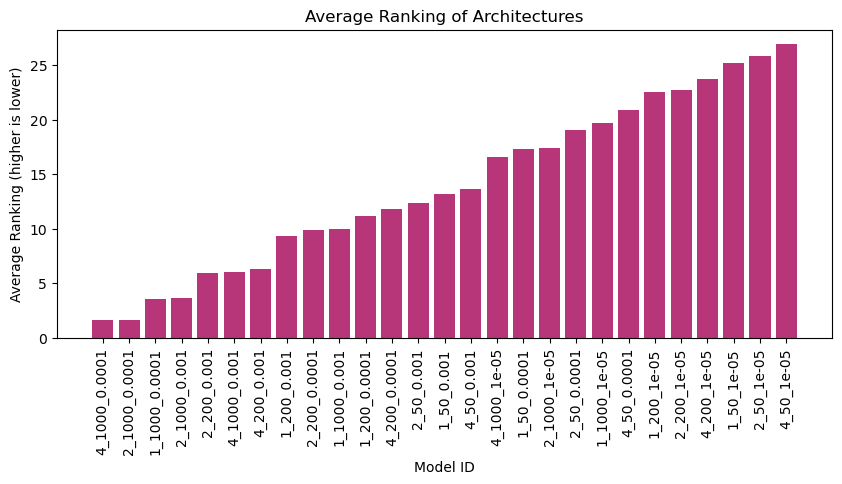

In [131]:
# Plot average ranking distribution
plt.figure(figsize=(10, 4))
plt.bar(x=average_rankings_OE['ID'], 
        height=average_rankings_OE['Ranking_OE'], 
        color="#B63679")

plt.xlabel('Model ID')
plt.ylabel('Average Ranking (higher is lower)')
plt.title('Average Ranking of Architectures')

# Rotate x labels for better readability
plt.xticks(rotation=90)

plt.show()

learning_rate: 1e-05
learning_rate: 0.0001
learning_rate: 0.001


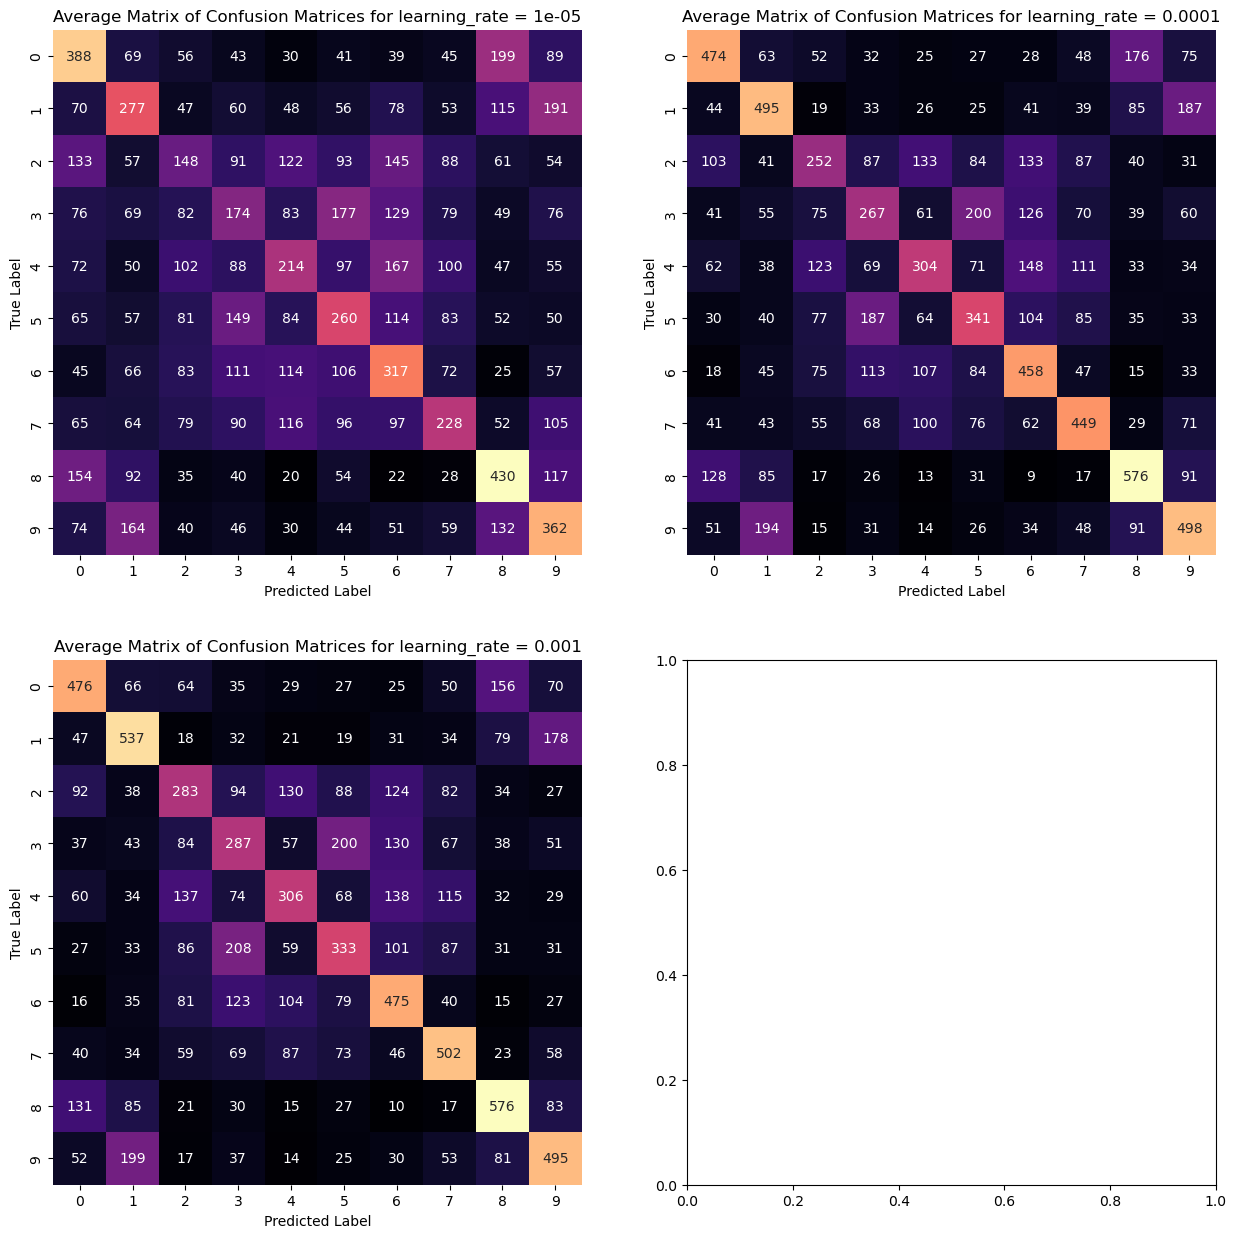

In [132]:
var_to_test = 'learning_rate'
fig, ax = plt.subplots(len(oe_50_runs[var_to_test].unique())//2 + 1, 2, figsize=(15, 15))
ax = ax.flatten()
for i, lr in enumerate(sorted(oe_50_runs[var_to_test].unique())):
    print(f'{var_to_test}: {lr}')
    lr_df = oe_50_runs[oe_50_runs[var_to_test] == lr]
    mean_matrix = np.mean(lr_df['confusion_matrices']).astype(int)
    plot_cm(mean_matrix, axis=ax[i])
    ax[i].set_title(f'Average Matrix of Confusion Matrices for {var_to_test} = {lr}')


Interestingly, the architectures with the lowest learning rate are all in the bottom positions of the rankings and have the worst average confusion matrix

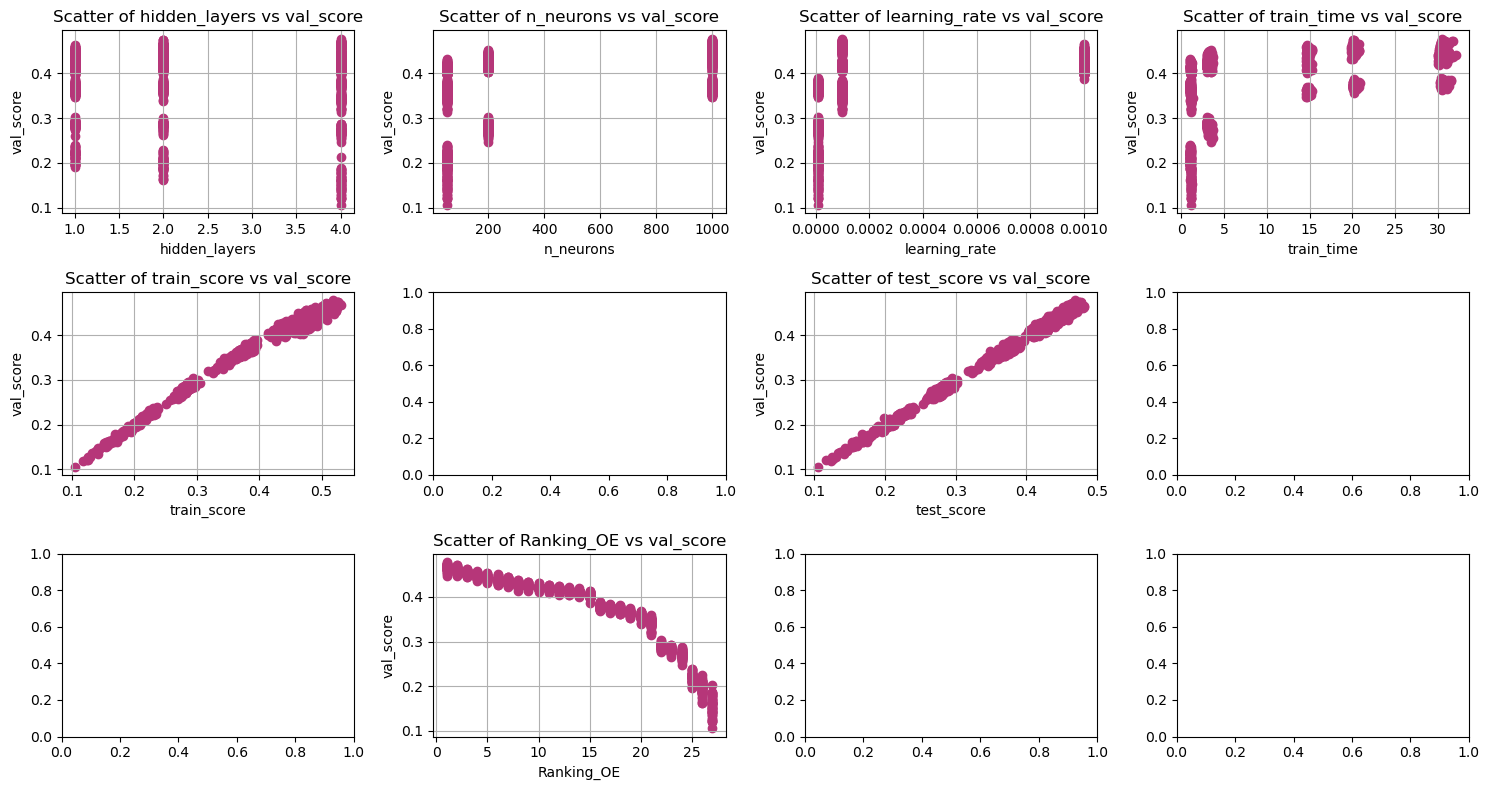

In [133]:
var_1 = 'hidden_layers'
var_2 = metric
fig, ax = plt.subplots(3, math.ceil(len(oe_50_runs.columns)//3 +1), figsize=(15, 8))
ax = ax.flatten()
for i, col in enumerate(oe_50_runs.columns):
    # print(f'Analyzing variable: {col}')
    if col in ['score', 'confusion_matrices', 'ID', var_2]:
        pass
    else:
        plot_correlation(oe_50_runs, col, var_2, ax=ax[i])

plt.tight_layout()

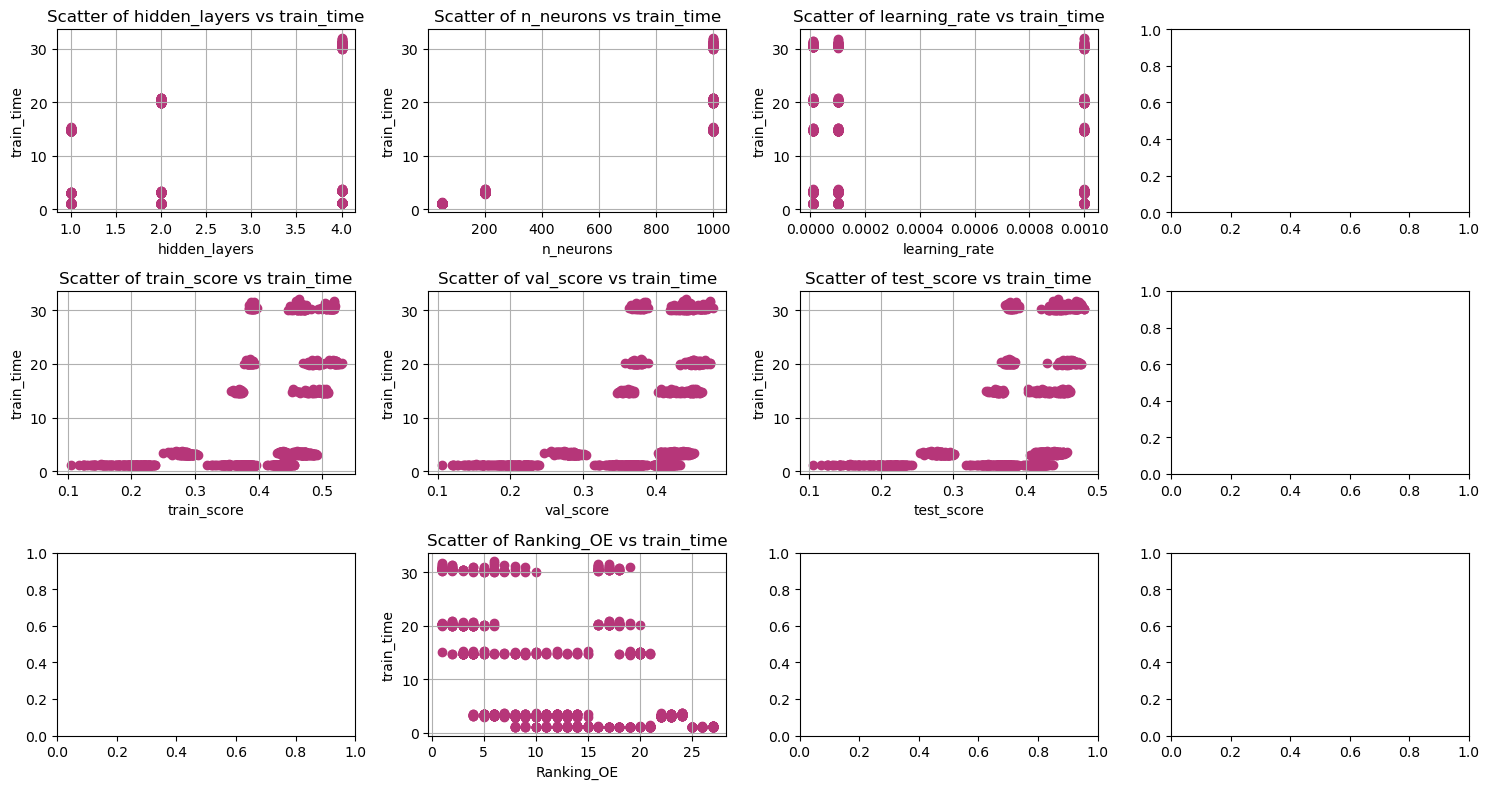

In [134]:
var_2 = 'train_time'
fig, ax = plt.subplots(3, math.ceil(len(oe_50_runs.columns)//3 +1), figsize=(15, 8))
ax = ax.flatten()
for i, col in enumerate(oe_50_runs.columns):
    # print(f'Analyzing variable: {col}')
    if col in ['confusion_matrices', 'ID', var_2]:
        pass
    else:
        plot_correlation(oe_50_runs, col, var_2, ax=ax[i])

plt.tight_layout()

Text(0.45, 4, '')

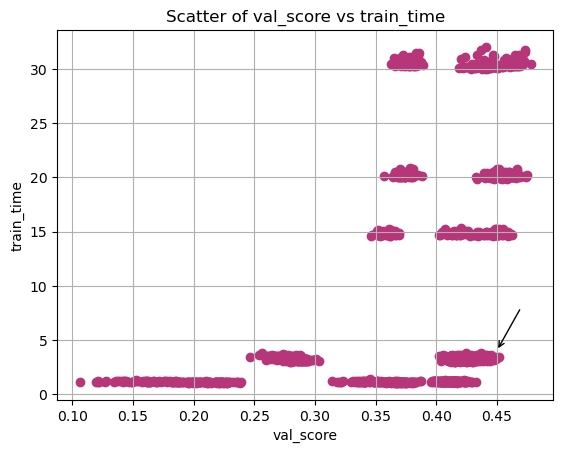

In [138]:
plot_correlation(oe_50_runs, metric, var_2)

# Coordinates for the arrow
arrow_start = (0.45, 4)
arrow_end = (0.47, 8)  
plt.annotate('', xy=arrow_end, xytext=arrow_start,
             arrowprops=dict(arrowstyle='<-', color='black', lw=1))